<a href="https://colab.research.google.com/github/hy-e/2025-ai-expert/blob/main/panorama_release.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

In [ ]:
import gdown
url = "https://drive.google.com/drive/folders/1R9Wvlu1fz2CGl_I48BbohW01fpnrPJ5J?usp=sharing"
gdown.download_folder(url, quiet=True)
%cd ds_hw

/content/ds_hw


# Goal

이번 실습은 SIFT feature를 추출하고, 매칭하는 과정을 통해 homography를 구하여 여러 장의 연속적인 이미지를 하나의 파노라마로 만드는 내용입니다. 구현이 잘 되었다면 노트북 하단부의 실행 블록에서 아래와 같은 이미지를 확인할 수 있을 것입니다. (위의 폴더 다운로드 블록을 실행한 뒤 아래 블록을 실행하시기 바랍니다)


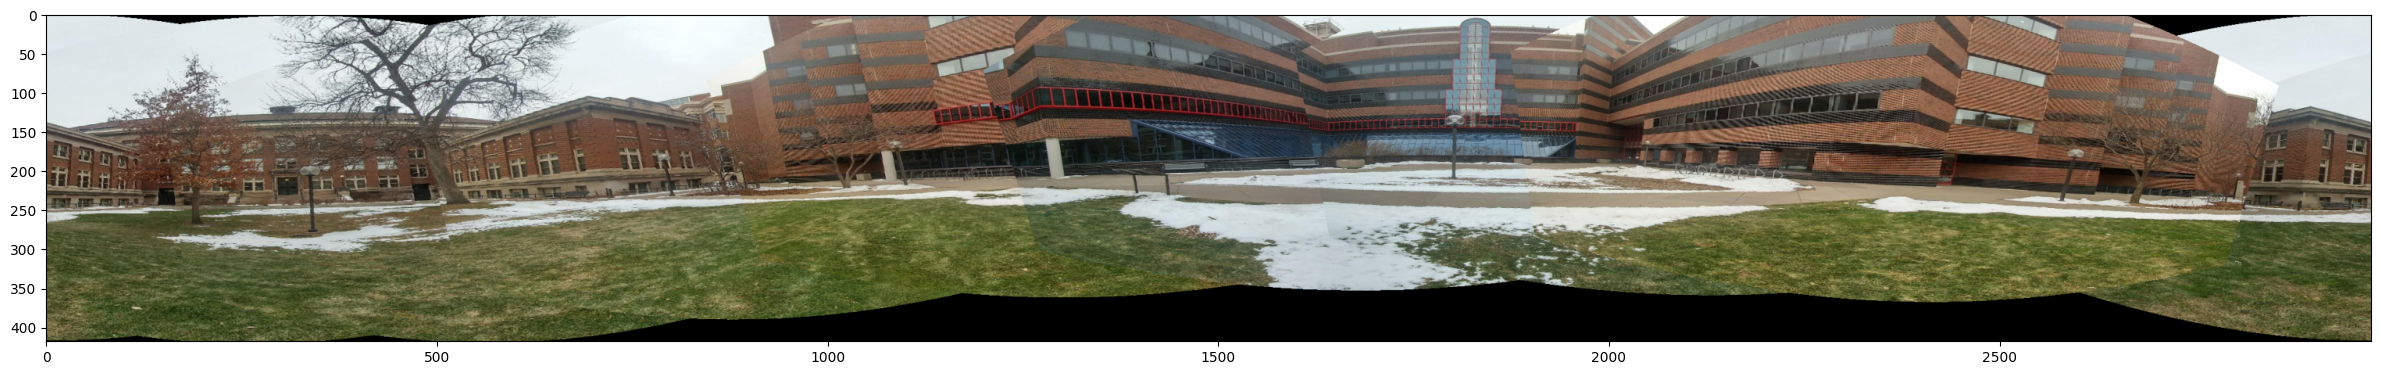

In [ ]:
expected = cv2.cvtColor(cv2.imread("/content/ds_hw/expected.png"), cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(30, 6))
ax.imshow(expected)

# Overview
이번 실습의 구조는 크게 네 블록으로 구성되어 있습니다
1. 이미지들 사이의 SIFT feature를 matching 시킴
2. Matching keypoint 사이의 homography를 구함
3. Homography를 이용하여 rotation을 구함
4. Rotation을 이용하여 이미지들을 하나의 canvas 위에 올림

여기서 4번은 이미 구현이 되어 있고, 1번부터 3번까지를 구현하는 것이 이번 실습의 목표입니다.


# 1. SIFT matching

 먼저 SIFT keypoint와 descriptor를 추출한 뒤 (앞서 구현되어 있음) matching하는 메서드를 구현할 것입니다. Opencv에 구현된 nearest neighbor를 사용하여 매칭을 구한 것 처럼 scikit-learn의 nearest neighbor를 사용할 것입니다(상단의 import를 참고하시기 바랍니다). 전체적인 과정은 최하단의 코드 블록을 활용할 수 있습니다. 이번 실습에서 설정할 threshold ratio는 0.7 입니다(혹은 사용하시고 싶은 matching 알고리즘을 사용하셔도 무방합니다).

 *Hint*
 *아래의 문서를 참고하시기 바랍니다*

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html

In [ ]:
def MatchSIFT(loc1, des1, loc2, des2):
    """
    Find the matches of SIFT features between two images

    Parameters
    ----------
    loc1 : ndarray of shape (n1, 2)
        Keypoint locations in image 1
    des1 : ndarray of shape (n1, 128)
        SIFT descriptors of the keypoints image 1
    loc2 : ndarray of shape (n2, 2)
        Keypoint locations in image 2
    des2 : ndarray of shape (n2, 128)
        SIFT descriptors of the keypoints image 2

    Returns
    -------
    x1 : ndarray of shape (n, 2)
        Matched keypoint locations in image 1
    x2 : ndarray of shape (n, 2)
        Matched keypoint locations in image 2
    """
    x1, x2 = None, None

    # TODO : Make matching algorithm

    return x1, x2

# 2. Estimate homography

적절한 matching을 구하였다면, 해당 대응점들을 이용하여 연속적인 이미지들(i번째와 (i+1)번째 사이) 사이의 homography를 구할것입니다. 강의 시간에서 다룬 것 처럼, Homography를 구하는 과정은 아래와 같습니다.

1. Ax = 0 형태로 matrix A를 구성함
2. A에 SVD(np.linalg.svd())를 적용하고 Homography를 구함
3. 구한 homography를 keypoint x1에 적용하여 x2의 공간으로 변환한 뒤 대응점들 사이의 pixel distance(error term으로 사용)를 구함.
4. 각 pixel distance를 ransac_thr와 비교하여 더 작은 범위 안에 있는 index의 갯수를 구함
5. ransac_n_iter 만큼 iteration을 돌며 가장 많은 inlier를 가지고 있는 homography와 그때의 inlier index를 반환

RANSAC의 구체적인 내용은 아래를 참고하시기 바랍니다.

https://en.wikipedia.org/wiki/Random_sample_consensus

https://darkpgmr.tistory.com/61

*Hint*

*scipy의 cdist를 적절히 이용하면 편리하게 거리를 구할 수 있습니다.*
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html

In [ ]:
def EstimateH(x1, x2, ransac_n_iter, ransac_thr):
    """
    Estimate the homography between images using RANSAC

    Parameters
    ----------
    x1 : ndarray of shape (n, 2)
        Matched keypoint locations in image 1
    x2 : ndarray of shape (n, 2)
        Matched keypoint locations in image 2
    ransac_n_iter : int
        Number of RANSAC iterations
    ransac_thr : float
        Error threshold for RANSAC

    Returns
    -------
    H : ndarray of shape (3, 3)
        The estimated homography
    inlier : ndarray of shape (k,)
        The inlier indices
    """
    numMax, maxHomography, maxInlier = 0, 0, 0
    # TODO : Make Homography estimation
    return maxHomography, maxInlier


# 3. Estimate rotation matrix
Homography를 구하였다면 rotation을 추출할 것입니다. 제공된 사진들이 pure rotation으로 구성되었기 때문에 아래의 rotation matrix만으로 파노라마를 구성할 수 있습니다.

Image 1에서 Image 2로의 homography H를 생각해보겠습니다. 그렇다면 대응점 $x_1, x_2$ 사이에 아래와 같은 관계가 성립하게 됩니다.
$$x_2 = H x_1$$
한편, 각 camera의 projection을 생각해보면 아래와 같습니다.
$$ P_1 = K [I | 0] $$
$$ P_2 = K [R | 0] = KR [I|0] $$
이를 이용하여 관계식을 구하면 아래와 같습니다.
$$ x_2 = P_2 X = KR [I|0] X = KRK^{-1}K[I|0]X = KRK^{-1}x_1$$

$$ x_2 = KRK^{-1} x_1$$
위에서 본 homography와 같은 구조가 되는 것을 확인할 수 있습니다. 그렇다면 $H=KRK^{-1}$에서 R을 바로 구하면 원하는 rotation R을 바로 구할 수 있을까요? 그렇지 않습니다. Homography는 upto scale로 같은 것이기 때문에 scaling을 해주어야 합니다.

 여기서 input으로 받는 H와 저희가 구할 rotation R은 upto scale로 같은 eigenvalue를 가지고 있습니다. 즉, 적절한 scale을 찾아서 input H에 적용을 해준 뒤, 강의 시간에 배운 식을 적용한다면 rotation을 구할 수 있습니다(혹은 SVD를 사용하여 eigenvector를 바로 구하는 방법도 있습니다). 이때 해당 scale은 input H의 determinant가 될 것입니다.

 마지막으로 Rotation matrix R은 아래의 조건을 만족해야 하는 것을 고려해야합니다.
$$ R^TR = I$$
$$ det(R) = 1 $$


In [ ]:
def EstimateR(H, K):
    """
    Compute the relative rotation matrix

    Parameters
    ----------
    H : ndarray of shape (3, 3)
        The estimated homography
    K : ndarray of shape (3, 3)
        The camera intrinsic parameters

    Returns
    -------
    R : ndarray of shape (3, 3)
        The relative rotation matrix from image 1 to image 2
    """
    rot = None
    # TODO : compute rotation
    return rot

아래부터는 구한 rotation과 제공된 intrinsic matrix K를 이용하여 이미지들을 하나의 파노라마 이미지로 합치는 과정입니다. 이미 구현이 되어 있으므로 어떻게 이미지들을 변환시키는지 참고하시기 바랍니다.

In [ ]:
def ConstructCylindricalCoord(Wc, Hc, K):
    """
    Generate 3D points on the cylindrical surface

    Parameters
    ----------
    Wc : int
        The width of the canvas
    Hc : int
        The height of the canvas
    K : ndarray of shape (3, 3)
        The camera intrinsic parameters of the source images

    Returns
    -------
    p : ndarray of shape (Hc, Hc, 3)
        The 3D points corresponding to all pixels in the canvas
    """
    p = np.zeros((Hc, Wc, 3))
    x = np.linspace(0,Wc-1, Wc).astype(int)
    y = np.linspace(0,Hc-1, Hc).astype(int)
    X, Y = np.meshgrid(x,y)
    # set as cartesian
    p[Y, X, 0] = K[0,0]*np.sin(2*np.pi*X/Wc) # x
    p[Y, X, 1] = Y-Hc/2 # y
    p[Y, X, 2] = K[0,0]*np.cos(2*np.pi*X/Wc) # z
    return p


def Projection(p, K, R, W, H):
    """
    Project the 3D points to the camera plane

    Parameters
    ----------
    p : ndarray of shape (Hc, Wc, 3)
        A set of 3D points that correspond to every pixel in the canvas image
    K : ndarray of shape (3, 3)
        The camera intrinsic parameters
    R : ndarray of shape (3, 3)
        The rotation matrix
    W : int
        The width of the source image
    H : int
        The height of the source image

    Returns
    -------
    u : ndarray of shape (Hc, Wc, 2)
        The 2D projection of the 3D points
    mask : ndarray of shape (Hc, Wc)
        The corresponding binary mask indicating valid pixels
    """
    Hc, Wc, _ = p.shape
    u = np.zeros((Hc, Wc, 2))
    mask = np.zeros((Hc,Wc))
    cam_mask = np.zeros((Hc,Wc))

    R = np.repeat(R[np.newaxis,:, :], Wc, axis=0)
    R = np.repeat(R[np.newaxis,:,:, :], Hc, axis=0)
    camCoord = np.matmul(R, p[:,:,:,np.newaxis])

    # Are the object points in front of camera?
    indices = np.argwhere((camCoord[:,:,2,0] > 0)) # where we should focus
    indy, indx = indices[:,0], indices[:,1]
    cam_mask[indy, indx] = 1# where cam looks

    # multiply intrinsic
    K_rep = np.repeat(K[np.newaxis,:,:], len(indy), axis=0)
    camCoord = camCoord[indy, indx,:,:]
    imgCoord = np.matmul(K_rep, camCoord)

    # Normalize
    imgCoord = imgCoord / imgCoord[:,2,0][:,None,None]

    # Are the points inside image boundaries?
    finalind = np.argwhere((imgCoord[:,0,0] >= 0) & (imgCoord[:,0,0] < W-1)
                & (imgCoord[:,1,0] >= 0) & (imgCoord[:,1,0] < H-1))


    u[indy[finalind], indx[finalind],0] = imgCoord[finalind,1,0]
    u[indy[finalind], indx[finalind],1] = imgCoord[finalind,0,0]
    mask[indy[finalind], indx[finalind]] = 1

    return u, mask


def WarpImage2Canvas(image_i, u, mask_i):
    """
    Warp the image to the cylindrical canvas

    Parameters
    ----------
    image_i : ndarray of shape (H, W, 3)
        The i-th image with width W and height H
    u : ndarray of shape (Hc, Wc, 2)
        The mapped 2D pixel locations in the source image for pixel transport
    mask_i : ndarray of shape (Hc, Wc)
        The valid pixel indicator

    Returns
    -------
    canvas_i : ndarray of shape (Hc, Wc, 3)
        the canvas image generated by the i-th source image
    """
    Hc, Wc, _  = u.shape
    canvas_i = np.zeros((Hc, Wc, 3))
    x = np.linspace(0,Wc-1, Wc).astype(int)
    y = np.linspace(0,Hc-1, Hc).astype(int)
    X, Y = np.meshgrid(x,y)

    Y_dl = np.floor(u[Y,X,0]).astype(int)
    X_dl = np.floor(u[Y,X,1]).astype(int)
    a, p = u[Y,X,0]-Y_dl,  u[Y,X,1]-X_dl
    b, q = 1-a, 1-p

    down_left = np.multiply(np.repeat(np.multiply(q,b)[:,:,np.newaxis], 3, axis=2), image_i[Y_dl, X_dl,:])
    up_left = np.multiply(np.repeat(np.multiply(q,a)[:,:,np.newaxis], 3, axis=2), image_i[Y_dl+1, X_dl,:])
    down_right = np.multiply(np.repeat(np.multiply(p,b)[:,:,np.newaxis], 3, axis=2),image_i[Y_dl, X_dl+1,:])
    up_right = np.multiply(np.repeat(np.multiply(p,a)[:,:,np.newaxis], 3, axis=2),image_i[Y_dl+1, X_dl+1,:])
    canvas_i = (down_left + up_left + down_right + up_right).astype(np.uint8)

    return canvas_i


def UpdateCanvas(canvas, canvas_i, mask_i):
    """
    Update the canvas with the new warped image

    Parameters
    ----------
    canvas : ndarray of shape (Hc, Wc, 3)
        The previously generated canvas
    canvas_i : ndarray of shape (Hc, Wc, 3)
        The i-th canvas
    mask_i : ndarray of shape (Hc, Wc)
        The mask of the valid pixels on the i-th canvas

    Returns
    -------
    canvas : ndarray of shape (Hc, Wc, 3)
        The updated canvas image
    """
    Y, X = np.where(mask_i==1)
    canvas[Y, X, :] = canvas_i[Y, X, :]

    return canvas

모든 메서드가 적절하게 구현되었다면, 아래의 코드를 실행시켰을때 파노라마가 생성되는 것을 확인할 수 있을 것입니다.

[[ 0.97752501 -0.01314855 -0.0784846 ]
 [-0.01314855  1.00406387  0.00629949]
 [-0.0784846   0.00629949  1.0253596 ]]
[[ 0.95836549 -0.01725569 -0.071529  ]
 [-0.01725569  1.01283544 -0.00229835]
 [-0.071529   -0.00229835  1.03588742]]
[[ 0.9687346  -0.00855821 -0.08325186]
 [-0.00855821  1.01148489 -0.01238016]
 [-0.08325186 -0.01238016  1.02795446]]
[[ 0.94935242 -0.0144987  -0.09328851]
 [-0.0144987   1.00443228  0.01374658]
 [-0.09328851  0.01374658  1.05825093]]
[[ 0.97267284 -0.03983584 -0.0831116 ]
 [-0.03983584  0.99499405 -0.00356996]
 [-0.0831116  -0.00356996  1.04211498]]
[[ 0.94258755 -0.04112769 -0.09724084]
 [-0.04112769  1.01683866 -0.02512136]
 [-0.09724084 -0.02512136  1.05606669]]
[[ 0.96926902 -0.01275954 -0.08135707]
 [-0.01275954  1.01543875  0.01136088]
 [-0.08135707  0.01136088  1.02312046]]


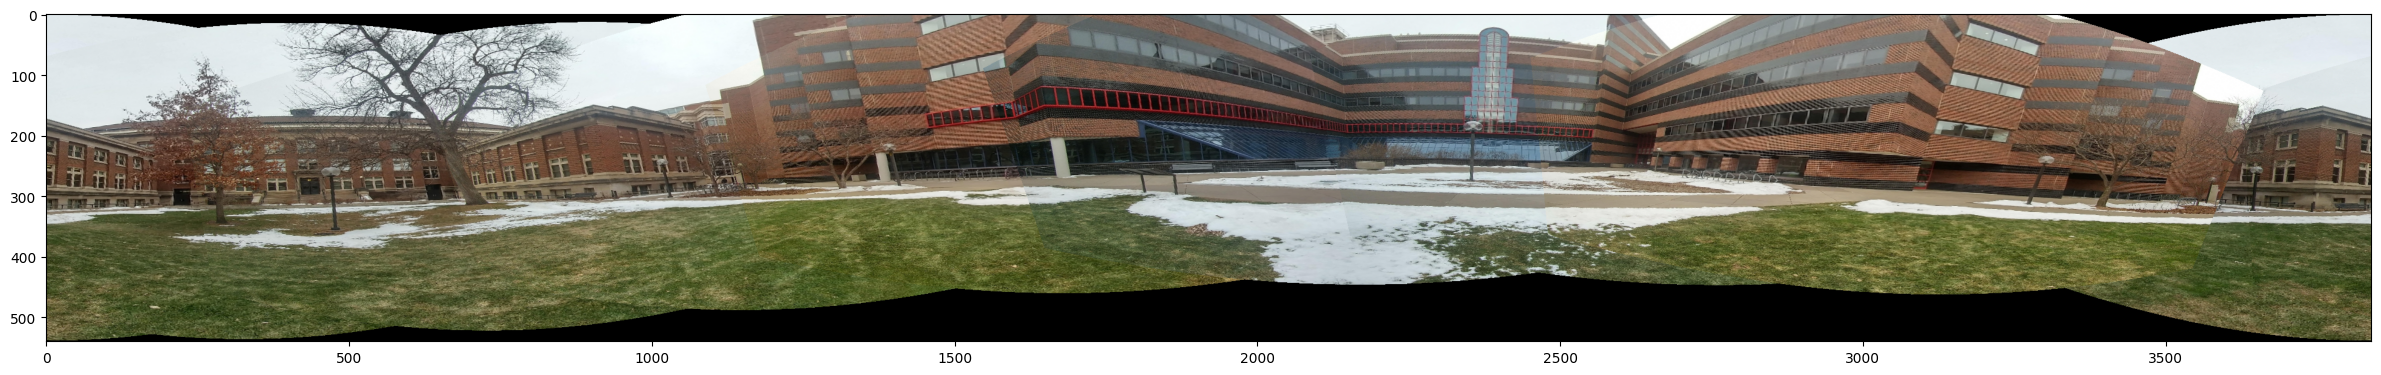

In [ ]:
ransac_n_iter = 500
ransac_thr = 3
K = np.asarray([
    [320, 0, 480],
    [0, 320, 270],
    [0, 0, 1]
])

# Read all images
im_list = []
for i in range(1, 9):
    im_file = '{}.jpg'.format(i)
    im = cv2.imread(im_file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_list.append(im)

rot_list = []
rot_list.append(np.eye(3)) # 처음 rotation matrix을 기준으로 생각
for i in range(len(im_list) - 1):
    # Load consecutive images I_i and I_{i+1}
    imgFor, imgLat = im_list[i],im_list[i+1]
    # Extract SIFT features
    sift = cv2.SIFT_create() # SIFT object 생성
    loc1, des1 = sift.detectAndCompute(imgFor, None)
    loc2, des2 = sift.detectAndCompute(imgLat, None)
    # Find the matches between two images (x1 <--> x2)
    loc1 = np.array(list(map(lambda v : [v.pt[0], v.pt[1]], loc1)))
    loc2 = np.array(list(map(lambda v : [v.pt[0], v.pt[1]], loc2)))
    x1, x2 = MatchSIFT(loc1, des1, loc2, des2)

    # Estimate the homography between images using RANSAC
    H, inlier = EstimateH(x1, x2, ransac_n_iter, ransac_thr)

    # Compute the relative rotation matrix R
    R = EstimateR(H, K)

    # Compute R_new (or R_i+1)
    R_new = R@rot_list[-1] # 직전 rotation들을 누적
    rot_list.append(R_new)

Him = im_list[0].shape[0]
Wim = im_list[0].shape[1]

Hc = Him
Wc = len(im_list) * Wim // 2

canvas = np.zeros((Hc, Wc, 3), dtype=np.uint8)
p = ConstructCylindricalCoord(Wc, Hc, K)

for i, (im_i, rot_i) in enumerate(zip(im_list, rot_list)):
    # Project the 3D points to the i-th camera plane
    u, mask_i = Projection(p, K, rot_i, Wim, Him)
    # Warp the image to the cylindrical canvas
    canvas_i = WarpImage2Canvas(im_i, u, mask_i)
    # Update the canvas with the new warped image
    canvas = UpdateCanvas(canvas, canvas_i, mask_i)
fig, ax = plt.subplots(figsize=(30, 6))
ax.imshow(canvas)